In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import sys 
import numpy as np 
import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
from six import add_metaclass
from contextlib import contextmanager
import random
import pickle

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
Pytorch: 1.4.0


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


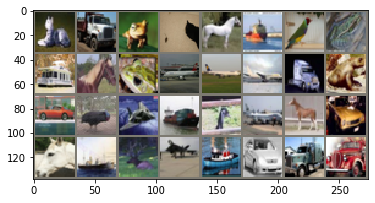

In [2]:
batch_size = 32
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),

    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('/home/fmejia/fmejia/Cypercat/cyphercat/datasets//', train=True, transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('/home/fmejia/fmejia/Cypercat/cyphercat/datasets//', train=False, transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img, filename = None):
    mean = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
    mean = mean.view(-1,1,1).cpu().detach().numpy()
    var = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
    var = var.view(-1,1,1).cpu().detach().numpy()
    
    img = np.array(img)
    img = (img*var) + mean
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    try:
        plt.savefig(filename)
        plt.show()
    except:
        plt.show()
    
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [3]:
##############################################################################
# ReparamModule
##############################################################################

class PatchModules(type):
    def __call__(cls, *args, **kwargs):
        r"""Called when you call ReparamModule(...) """
        net = type.__call__(cls, *args, **kwargs)

        # collect weight (module, name) pairs
        # flatten weights
        w_modules_names = []

        for m in net.modules():
            for n, p in m.named_parameters(recurse=False):
                if p is not None:
                    w_modules_names.append((m, n))
            for n, b in m.named_buffers(recurse=False):
                if b is not None:
                    print((
                        '{} contains buffer {}. The buffer will be treated as '
                        'a constant and assumed not to change during gradient '
                        'steps. If this assumption is violated (e.g., '
                        'BatchNorm*d\'s running_mean/var), the computation will '
                        'be incorrect.').format(m.__class__.__name__, n))

        net._weights_module_names = tuple(w_modules_names)

        # Put to correct device before we do stuff on parameters
        net = net.to(device)

        ws = tuple(m._parameters[n].detach() for m, n in w_modules_names)

        assert len(set(w.dtype for w in ws)) == 1

        # reparam to a single flat parameter
        net._weights_numels = tuple(w.numel() for w in ws)
        net._weights_shapes = tuple(w.shape for w in ws)
        with torch.no_grad():
            flat_w = torch.cat([w.reshape(-1) for w in ws], 0)

        # remove old parameters, assign the names as buffers
        for m, n in net._weights_module_names:
            delattr(m, n)
            m.register_buffer(n, None)

        # register the flat one
        net.register_parameter('flat_w', nn.Parameter(flat_w, requires_grad=True))

        return net


@add_metaclass(PatchModules)
class ReparamModule(nn.Module):
    def _apply(self, *args, **kwargs):
        rv = super(ReparamModule, self)._apply(*args, **kwargs)
        return rv

    def get_param(self, clone=False):
        if clone:
            return self.flat_w.detach().clone().requires_grad_(self.flat_w.requires_grad)
        return self.flat_w
    
    @contextmanager
    def unflatten_weight(self, flat_w):
        ws = (t.view(s) for (t, s) in zip(flat_w.split(self._weights_numels), self._weights_shapes))
        for (m, n), w in zip(self._weights_module_names, ws):
            setattr(m, n, w)
        yield
        for m, n in self._weights_module_names:
            setattr(m, n, None)            

    def forward_with_param(self, inp, new_w):
        with self.unflatten_weight(new_w):
            return nn.Module.__call__(self, inp)

    def __call__(self, inp):
        return self.forward_with_param(inp, self.flat_w)

    # make load_state_dict work on both
    # singleton dicts containing a flattened weight tensor and
    # full dicts containing unflattened weight tensors...
    def load_state_dict(self, state_dict, *args, **kwargs):
        if len(state_dict) == 1 and 'flat_w' in state_dict:
            return super(ReparamModule, self).load_state_dict(state_dict, *args, **kwargs)
        with self.unflatten_weight(self.flat_w):
            flat_w = self.flat_w
            del self.flat_w
            super(ReparamModule, self).load_state_dict(state_dict, *args, **kwargs)
        self.register_parameter('flat_w', flat_w)

    def reset(self, inplace=True):
        if inplace:
            flat_w = self.flat_w
        else:
            flat_w = torch.empty_like(self.flat_w).requires_grad_()
        with torch.no_grad():
            with self.unflatten_weight(flat_w):
                weights_init(self)
        return flat_w

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class wide_basic(ReparamModule):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
#         self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
#         out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv1(F.leaky_relu(self.bn1(x), 0.1))
        out = self.conv2(F.leaky_relu(self.bn2(out), 0.1))
        out += self.shortcut(x)

        return out

class Wide_ResNet(ReparamModule):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = int((depth-4)/6)
        k = widen_factor

#         print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.leaky_relu(self.bn1(out), 0.1)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out
    
net = Wide_ResNet(28, 10, 0.3, 10)
net = net.to(device)
out = net(imgs.to(device))

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

In [5]:
def ga_PGD(image, net, iterations, lr,category, verbose = True):        
    if iterations == 0:
        return image
    category = category.to(device)
        
    image = image.cuda()
    
    input_orig = Variable(image, requires_grad=False).to(device)
    
    losses = []
    losses2 = []
    modifier = torch.tensor(np.random.uniform(-10/255*2.78, 10/255*2.78, image.size())).float().to(device)
    modifier_var = Variable(modifier, requires_grad=True)
    var = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
    var = var.view(-1,1,1)
    
    optimizer = optim.Adam([modifier_var], lr)
    alpha = 2/255*2.78
    for j in range(iterations):      
        
        net.zero_grad()
        input_adv = torch.clamp(torch.clamp(modifier_var,-10/255*2.78, 10/255*2.78) + input_orig, -2.78, 2.78)
#         input_adv = torch.clamp(modifier_var + input_orig, -2.78, 2.78)        
        out = net(input_adv)
        loss_class = class_criterion(out,category)
        loss_class.backward()
        modifier_var.data = modifier_var + alpha*modifier_var.grad.detach().sign()                
        modifier_var.grad.zero_()
        
    if verbose:
        losses.append(loss_class.data)
        plt.plot(losses)
        plt.show()
    
    return input_adv


# def adv_train(net, data_loader, test_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
#     losses = []
    
#     for epoch in range(n_epochs):
#         net.train()
#         total = 0
#         correct = 0
#         for i, batch in enumerate(data_loader):

#             imgs, labels = batch
#             imgs, labels = imgs.to(device), labels.to(device)

#             optimizer.zero_grad()

#             im_fool= ga_PGD(imgs,net,10,1e-1,labels,False).detach()
#             outputs = net(im_fool)
            
#             ## accuracy calc
#             predicted = outputs.argmax(dim=1)
#             total += imgs.size(0)
#             correct += predicted.eq(labels).sum().item()

#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             losses.append(loss.data)
#             if verbose:
#                 print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

#         # evaluate performance on testset at the end of each epoch
#         print("[%d/%d]" %(epoch, n_epochs))
#         plt.plot(losses)
#         plt.show()
#         print("Train Accuracy %f" %(correct/total*100))
#         if epoch%10 == 0:
#             torch.save(net, 'CIFAR10_VGG_trained_robust%i.pt' %epoch)
            
#     return losses

# n_classes = 10
# class_criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0002)  
# try:
#     losses
# except:       
#     losses = []
    

# losses = losses + adv_train(net, cifar10_trainloader, cifar10_testloader, optimizer, class_criterion, n_epochs= 30, verbose=False)
# torch.save(net, 'CIFAR10_VGG_trained_robust_full.pt')

In [6]:
def weights_init(m):
    def init_func(m):
        classname = m.__class__.__name__
        if classname.startswith('Conv') or classname == 'Linear':
            if getattr(m, 'bias', None) is not None:
                nn.init.constant_(m.bias, 0.0)
            if getattr(m, 'weight', None) is not None:
                if classname == 'Linear':           
                    nn.init.xavier_normal_(m.weight)
                if classname.startswith('Conv'):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

        elif 'Norm' in classname:
            if getattr(m, 'weight', None) is not None:
                m.weight.data.fill_(1)
            if getattr(m, 'bias', None) is not None:
                m.bias.data.zero_()
    m.apply(init_func)
    return(m)

In [7]:
net = Wide_ResNet(28, 10, 0.3, 10)
net.reset() 
net = net.to(device)
w = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = True).to(device)
n_classes = 10
class_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0002) 
net = torch.load('CIFAR10_VGG_trained_robust_full.pt')
net = net.to(device)
w0 = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = False).to(device)

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

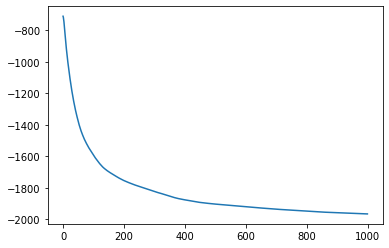

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


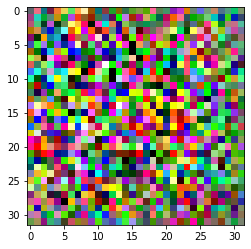

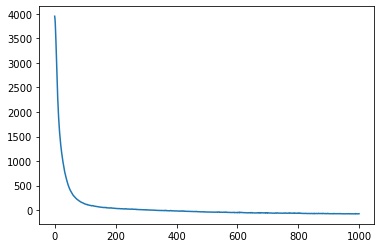

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


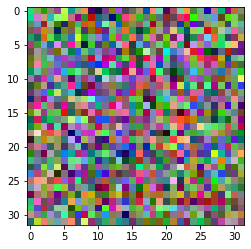

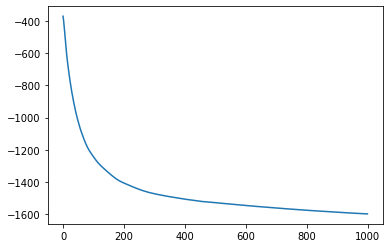

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


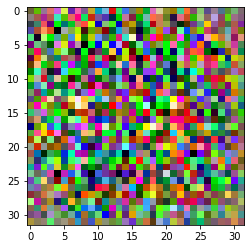

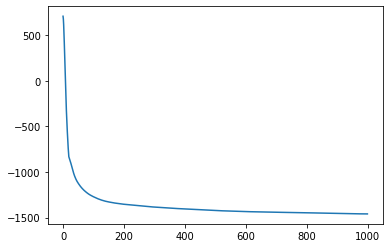

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


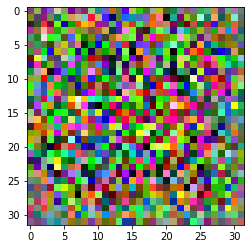

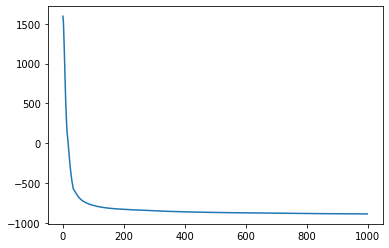

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


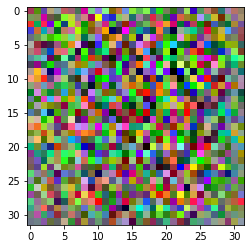

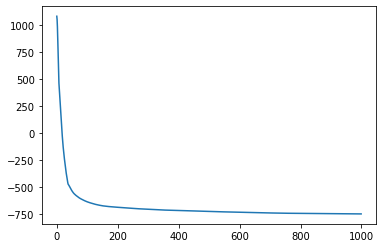

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


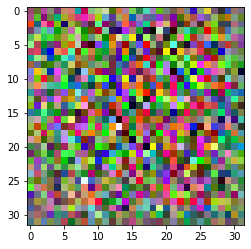

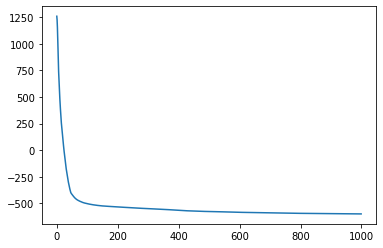

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


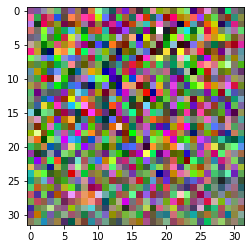

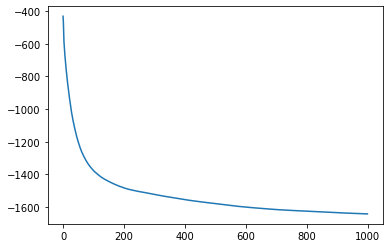

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


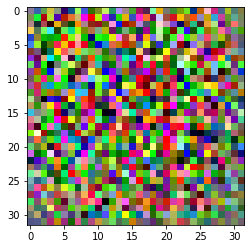

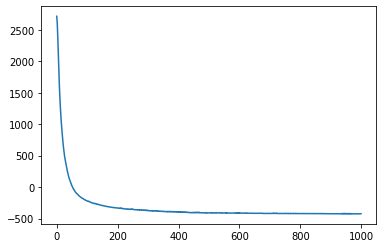

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


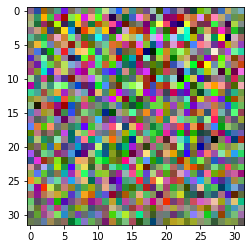

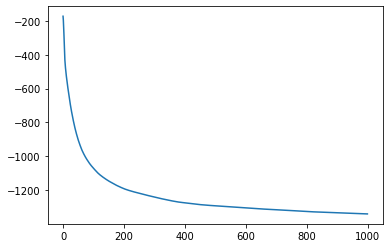

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


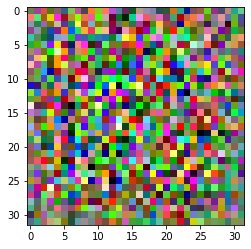

In [8]:
def ga(image, net, iterations, lr,category):   

    optimizer = optim.SGD([image], lr = lr, momentum=0.9, weight_decay=0.1)
    category = torch.tensor(np.array(i)).long().to(device)
    losses = []
    net.eval()
    for j in range(iterations):
        
#         out = net(image) 
        out = net.forward_with_param(image, w)
        loss = - 2 * out.take(category) + out.max() 
        loss.backward()
        optimizer.step()
        image.data = torch.clamp(image.data,-2.7537,2.7537)
        image.grad.zero_()        
        losses.append(loss.data)

    plt.plot(losses)
    plt.show()
   
    return image.detach(), losses

p = np.random.uniform(size = (1,3,32,32), low = -2.7, high = 2.7)
synthetic_imgs = torch.tensor(p, requires_grad = True, device = device, dtype = torch.float)
imgs_adv = torch.zeros((10,3,32,32))
# synthetic_imgs = torch.zeros(1,3,32,32, requires_grad=True, device = "cuda")

for i, class_id in enumerate(classes):
    imgs_adv[i,:,:,:], _ = ga(synthetic_imgs,net,1000,1e-2,i)
    imshow(imgs_adv[i,:,:,:].squeeze().cpu().detach().numpy())
    plt.show()
    

In [10]:
def eval_target_net(net, testloader, classes=None):

    if classes is not None:
        class_correct = np.zeros(10)
        class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(testloader):

            imgs, lbls = imgs.to(device), lbls.to(device)

            output = net(imgs)

            predicted = output.argmax(dim=1)

            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()

            if classes is not None:
                for prediction, lbl in zip(predicted, lbls):

                    class_correct[lbl] += prediction == lbl
                    class_total[lbl] += 1
                    
    accuracy = 100*(correct/total)
    if classes is not None:
        for i in range(len(classes)):
            print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nAccuracy = %.2f %%\n\n" % (accuracy) )
    
    return accuracy
eval_target_net(net, cifar10_testloader)


Accuracy = 81.51 %




81.51

In [8]:
class MyDataset():
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        data, target = self.dataset[index]        
        return data, target, index

    def __len__(self):
        return len(self.dataset)

trainset = MyDataset(cifar10_trainset)
cifar10_trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=2)


BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


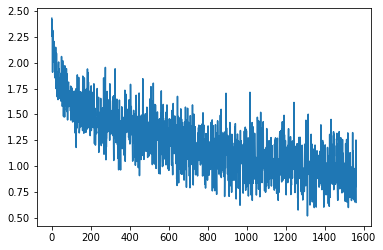

tensor(2435.0300, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


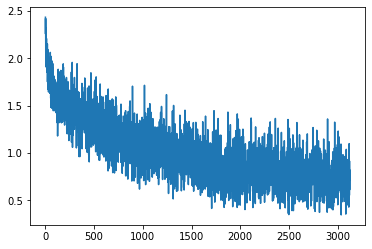

tensor(2435.7905, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


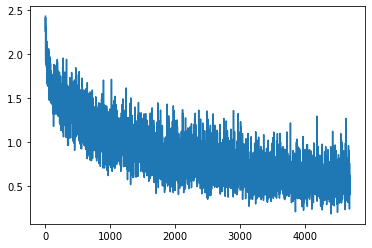

tensor(2436.3042, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


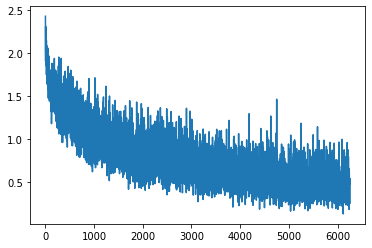

tensor(2436.4531, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


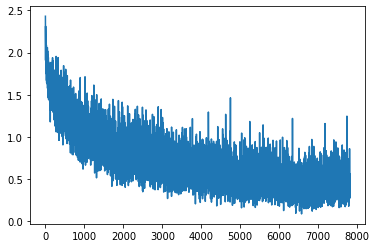

tensor(2436.3560, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


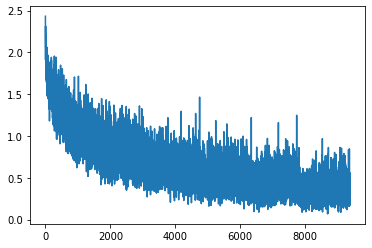

tensor(2435.9880, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


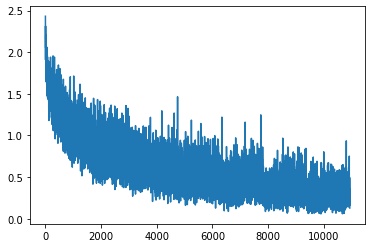

tensor(2435.3198, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


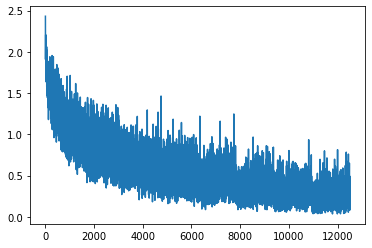

tensor(2434.6870, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


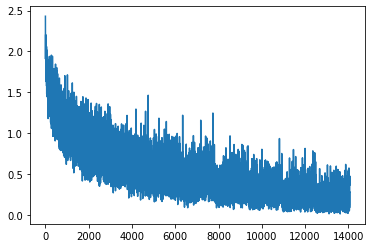

tensor(2433.8574, device='cuda:1', grad_fn=<SumBackward0>)
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation wi

BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer num_batches_tracked. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_mean. The buffer will be treated as a constant and assumed not to change during gradient steps. If this assumption is violated (e.g., BatchNorm*d's running_mean/var), the computation will be incorrect.
BatchNorm2d contains buffer running_var. T

accuracy plots
epoch 0


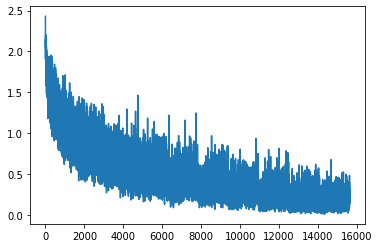

tensor(2433.1641, device='cuda:1', grad_fn=<SumBackward0>)


In [9]:
n_epochs = 1
n_restarts = 10
lr = 0.01
lr_synthetic = 1e2
modifier = torch.tensor(np.random.uniform(-10/255*2.78, 10/255*2.78, (50000,3,32,32))).float().to(device)
modifier_var = Variable(modifier, requires_grad=True)
losses_syn = []  
for ii in range(n_restarts):
    for epoch in range(n_epochs):
        net = Wide_ResNet(28, 10, 0.3, 10)
        net.reset() 
        net.train()
        for i, batch in enumerate(cifar10_trainloader):
            dgw = w - w0 
            imgs, labels, ind = batch
            imgs, labels = imgs.to(device), labels.to(device)
            ## train with generated
    #         imgs = imgs + modifier_var
            ww = torch.clamp(modifier_var[ind,:,:,:],-10/255*2.78, 10/255*2.78)
            input_adv = torch.clamp(ww + imgs, -2.78, 2.78)
            with torch.enable_grad():
                outputs = net.forward_with_param(input_adv, w)
                loss = class_criterion(outputs, labels)
            losses_syn.append(loss.item())
            gw, = torch.autograd.grad(loss, w, grad_outputs = torch.tensor(lr).to(device).requires_grad_() ,create_graph=True) 
            hvp_grad = torch.autograd.grad(
                outputs=(gw,),
                inputs=[ww],
                grad_outputs=(dgw,)
            )

            for ii, index0 in enumerate(ind):
                modifier_var[index0,:,:,:] = modifier_var[index0,:,:,:] - lr_synthetic * hvp_grad[0][ii] 
    #         break
            net.zero_grad()
            with torch.no_grad():
                w = w.sub(gw).requires_grad_()
        print('accuracy plots')
        print('epoch ' + str(epoch))
        plt.plot(losses_syn)
        plt.show() 
        print((w*w0).sum())
        with open('CIFAR_data_purification.pickle', 'wb') as f:
            pickle.dump(modifier_var, f)

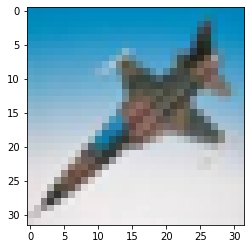

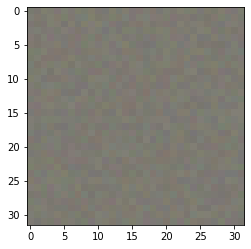

In [12]:
ind0 = 1
imshow(imgs[ind0,:,:,:].squeeze().cpu().detach().numpy())
imshow(modifier_var[ind[ind0],:,:,:].squeeze().cpu().detach().numpy())

In [11]:
testset = MyDataset(cifar10_testset)
cifar10_testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True, num_workers=2)
def eval_target_net(net, testloader, classes=None):

    if classes is not None:
        class_correct = np.zeros(10)
        class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls,_) in enumerate(testloader):

            imgs, lbls = imgs.to(device), lbls.to(device)

            output = net(imgs)

            predicted = output.argmax(dim=1)

            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()

            if classes is not None:
                for prediction, lbl in zip(predicted, lbls):

                    class_correct[lbl] += prediction == lbl
                    class_total[lbl] += 1
             
    if classes is not None:
        for i in range(len(classes)):
            print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nTotal accuracy = %.2f %%\n\n" % (100*(correct/total)) )
    
    return((100*(correct/total)))
eval_target_net(net, cifar10_trainloader, classes=classes)
eval_target_net(net, cifar10_testloader, classes=classes)

Accuracy of airplane : 91.10 %
Accuracy of automobile : 87.20 %
Accuracy of bird : 63.40 %
Accuracy of cat : 67.90 %
Accuracy of deer : 87.70 %
Accuracy of dog : 66.30 %
Accuracy of frog : 88.50 %
Accuracy of horse : 81.80 %
Accuracy of ship : 90.70 %
Accuracy of truck : 90.50 %

Total accuracy = 81.51 %




81.51

In [ ]:
n_restarts = 100
lr = 0.01


losses = []  
losses_syn = []
losses_miss = []
losses_miss2 = []
accuracy = []
criterion_miss2 = nn.BCEWithLogitsLoss()
criterion_miss = nn.L1Loss()
# ww = torch.tensor(data_weights[ind], requires_grad=True, device = device)
# optimizer = optim.SGD([ww], lr = lr_synthetic, momentum=0.9)
grad_val = []
# for i in range(1000):
n_epoch = 10
n_restarts = 1
data_weights = torch.zeros(len(cifar10_trainloader.dataset), requires_grad=True, device = device)
for ii in range(n_restarts):
    
    seed_everything()  
    net = VGG()
    net.reset() 
    optimizer_model1 = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
    net.train()
        
    
    w = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = True).to(device)    
    
    for jj in range(n_epoch):

        for batch_train in cifar10_trainloader:
            imgs, labels, ind = batch_train
            imgs, labels = imgs.to(device), labels.to(device)
            ww = (torch.ones(ind.size(), requires_grad=True, device = device))
            ## train with generated
            with torch.enable_grad():
                output = net.forward_with_param(imgs, w)
                loss = weighted_cross_entropy(output, labels, ww)
            losses_syn.append(loss.item())
            gw, = torch.autograd.grad(loss, w, grad_outputs = torch.tensor(lr).to(device).requires_grad_() ,create_graph=True) 
            net.zero_grad()            
            with torch.no_grad():
                w = w.sub(gw).requires_grad_()
        print('accuracy plots')
        print('epoch ' + str(jj))
        plt.plot(losses_syn)
        plt.show() 
        
    w0 = torch.tensor(net.get_param().cpu().detach().numpy()).to(device) 
    seed_everything()  
    net = VGG()
    net.reset() 
    optimizer_model1 = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
    net.train()
    
    w = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = True).to(device)
    
    for jj in range(n_epoch):
        
        for batch_train in cifar10_trainloader:
            dgw = w - w0 
            imgs, labels, ind = batch_train
            imgs, labels = imgs.to(device), labels.to(device)
            ## train with generated
            ww = (torch.ones(ind.size(), requires_grad=True, device = device))
            with torch.enable_grad():
                output = net.forward_with_param(imgs, w)
                loss = weighted_cross_entropy(output, labels, ww)
            losses_syn.append(loss.item())
            gw, = torch.autograd.grad(loss, w, grad_outputs = torch.tensor(lr).to(device).requires_grad_() ,create_graph=True) 
            hvp_grad = torch.autograd.grad(
                outputs=(gw,),
                inputs=[ww],
                grad_outputs=(dgw,)
            )
            data_grad = torch.zeros(50000).to(device)
            for ii, index0 in enumerate(ind):
                data_grad[index0] = hvp_grad[0][ii]
            data_weights.data = data_weights.data - lr_synthetic * data_grad            
            net.zero_grad()
            with torch.no_grad():
                w = w.sub(gw).requires_grad_()
        print('accuracy plots')
        print('epoch ' + str(jj))
        plt.plot(losses_syn)
        plt.show()        


torch.Size([128, 3, 32, 32])